In [1]:
# Import required packages:
import os
import csv
import copy
import time
import sys
from pathlib import Path
from typing import Any, Callable, Optional
from PIL import Image
import torch
import torchvision.models.segmentation as models
from torchvision import transforms
from torchvision.datasets.vision import VisionDataset
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score
import numpy as np
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import gdown

# **Download Training/Test Set**

In [2]:
# Obtain the dataset using its dowloadable public Google Drive link and unzip it.
# Data used for this exercise is small subset of the Crack Forest Dataset 
# shared here: https://www.kaggle.com/mahendrachouhanml/crackforest
fileURL = 'https://drive.google.com/uc?export=download&id=1TN2FfJku5H5kukFkNSbVypMapSVjkcqC'
fileOut = 'dataset.zip'
gdown.download(fileURL, fileOut, quiet=False)

!unzip dataset.zip -d dataset
data_path = 'dataset'

Downloading...
From: https://drive.google.com/uc?export=download&id=1TN2FfJku5H5kukFkNSbVypMapSVjkcqC
To: /content/dataset.zip
3.80MB [00:00, 259MB/s]

Archive:  dataset.zip
   creating: dataset/test/
   creating: dataset/test/images/
  inflating: dataset/test/images/100.jpg  
  inflating: dataset/test/images/101.jpg  
  inflating: dataset/test/images/102.jpg  
  inflating: dataset/test/images/103.jpg  
  inflating: dataset/test/images/104.jpg  
  inflating: dataset/test/images/105.jpg  
  inflating: dataset/test/images/106.jpg  
  inflating: dataset/test/images/107.jpg  
  inflating: dataset/test/images/108.jpg  
  inflating: dataset/test/images/109.jpg  
  inflating: dataset/test/images/110.jpg  
  inflating: dataset/test/images/111.jpg  
  inflating: dataset/test/images/112.jpg  
  inflating: dataset/test/images/113.jpg  
  inflating: dataset/test/images/114.jpg  
  inflating: dataset/test/images/115.jpg  
  inflating: dataset/test/images/116.jpg  
  inflating: dataset/test/images/117.jpg  
  inflating: dataset/test/images/118.jpg  
   creating: dataset/test/masks/
  inflating: dataset/test/masks/100_label.PNG  
 extracting: datase

# **Train a Segmentation Model**

In [3]:
# Define the dataset class object expected by the Pytorch model:
class Dataset(VisionDataset):
    def __init__(self,
                 root: str,
                 imageFolder: str,
                 maskFolder: str,
                 transforms: Optional[Callable] = None) -> None:

        super().__init__(root, transforms)
        imageFolderPath = Path(self.root) / imageFolder
        maskFolderPath = Path(self.root) / maskFolder
        if not imageFolderPath.exists():
            raise OSError(f"{imageFolderPath} does not exist!")
        if not maskFolderPath.exists():
            raise OSError(f"{maskFolderPath} does not exist!")

        self.image_names = sorted(imageFolderPath.glob("*"))
        self.mask_names = sorted(maskFolderPath.glob("*"))

    def __len__(self) -> int:
        return len(self.image_names)

    def __getitem__(self, index: int) -> Any:
        imagePath = self.image_names[index]
        maskPath = self.mask_names[index]
        with open(imagePath, "rb") as imFile, open(maskPath,
                                                        "rb") as maskFile:
            image = Image.open(imFile); 
            mask = Image.open(maskFile); 
            sample = {"image": image, "mask": mask}
            if self.transforms:
                sample["image"] = self.transforms(sample["image"])
                sample["mask"] = self.transforms(sample["mask"])
            return sample

# Specify the Model Architecture
model = models.deeplabv3_resnet101(pretrained=True,progress=True)
model.classifier = models.deeplabv3.DeepLabHead(2048,1)

# Define Optimizer    
modelOptim = torch.optim.Adam(model.parameters(), lr = 1e-4)

# Define Loss Function 
lossFnc = torch.nn.MSELoss(reduction='mean')

# Set Training and Validation Datasets
dataTransforms = transforms.Compose([transforms.ToTensor()])

# Specify the number of training epochs:
nEpochs = 10

segdata = {
    x: Dataset(root=Path(data_path) / x,
    imageFolder="images",
    maskFolder="masks",
    transforms=dataTransforms)
    for x in ["train", "valid"]
    }

dataLoaders = {
    x: DataLoader(segdata[x],
                    batch_size=2,
                    shuffle=True,
                    num_workers=0)
    for x in ["train", "valid"]    
    }

# Set training device:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Create and initialize training log file
#perfMetrics = {"f1-score": f1_score, "auroc": roc_auc_score}
perfMetrics = {"f1-score": f1_score}
fieldnames = ['epoch', 'train_loss', 'valid_loss'] + \
    [f'train_{m}' for m in perfMetrics.keys()] + \
    [f'valid_{m}' for m in perfMetrics.keys()]
with open(os.path.join('log.csv'), 'w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

#model = torch.load('trainedModel25.pth')
# Train
startTimer = time.time()
for epoch in range(0,nEpochs):
    print('-' * 60)
    print("Epoch: {}/{}".format(epoch+1,nEpochs))
    batchsummary = {a: [0] for a in fieldnames}

    for phase in ["train", "valid"]:
        if phase == 'train':
            model.train()
        else:
            model.eval()
        # Iterate over data.
        for sample in tqdm(iter(dataLoaders[phase]), file=sys.stdout):
            inputs = sample['image'].to(device)
            masks = sample['mask'].to(device)
            # zero the parameter gradients
            modelOptim.zero_grad()

            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                loss = lossFnc(outputs['out'], masks)
                y_pred = outputs['out'].data.cpu().numpy().ravel()
                y_true = masks.data.cpu().numpy().ravel()
                for name, metric in perfMetrics.items():
                    if name == 'f1-score':
                        # Use a classification threshold of 0.1
                        batchsummary[f'{phase}_{name}'].append(
                            metric(y_true > 0, y_pred > 0.1))
                          
                    else:
                        batchsummary[f'{phase}_{name}'].append(
                            metric(y_true.astype('uint8'), y_pred))

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    modelOptim.step()
        batchsummary['epoch'] = epoch
        epoch_loss = loss
        batchsummary[f'{phase}_loss'] = epoch_loss.item()
    for field in fieldnames[3:]:
        batchsummary[field] = np.mean(batchsummary[field])
    print((f'train loss: {batchsummary["train_loss"]: .4f}, '
            f'valid loss: {batchsummary["valid_loss"]: .4f}, '
            f'train f1-score: {batchsummary["train_f1-score"]: .4f}, '
            f'valid f1-score: {batchsummary["valid_f1-score"]: .4f}, '))
            #f'train auroc: {batchsummary["train_auroc"]: .4f}, '
            #f'valid auroc: {batchsummary["valid_auroc"]: .4f}, '))
    with open(os.path.join('log.csv'), 'a', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writerow(batchsummary)
        # deep copy the model
        if phase == 'valid' and loss < 1e10:
            best_loss = loss
            best_model_wts = copy.deepcopy(model.state_dict())

time_elapsed = time.time() - startTimer
print('-' * 60)
print('Training completed in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
print(f'Lowest validation loss: {best_loss: .4f}')

# Load best model weights and save the best model:
model.load_state_dict(best_model_wts)
torch.save(model, 'crackdetector.pth')

# No need to worry about the Pytorch warning message. It will be fixed in version 
# 1.9.1 as stated here https://github.com/pytorch/pytorch/issues/60053

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth



------------------------------------------------------------
Epoch: 1/10
  0%|          | 0/40 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


100%|██████████| 10/10 [00:02<00:00,  4.95it/s]
train loss:  0.0262, valid loss:  0.0169, train f1-score:  0.0490, valid f1-score:  0.0684, 
------------------------------------------------------------
Epoch: 2/10
100%|██████████| 10/10 [00:02<00:00,  4.97it/s]
train loss:  0.0156, valid loss:  0.0833, train f1-score:  0.0953, valid f1-score:  0.1581, 
------------------------------------------------------------
Epoch: 3/10
100%|██████████| 10/10 [00:02<00:00,  4.93it/s]
train loss:  0.0210, valid loss:  0.0128, train f1-score:  0.1451, valid f1-score:  0.1569, 
------------------------------------------------------------
Epoch: 4/10
100%|██████████| 10/10 [00:02<00:00,  4.93it/s]
train loss:  0.0131, valid loss:  0.0164, train f1-score:  0.1876, valid f1-score:  0.2311, 
------------------------------------------------------------
Epoch: 5/10
100%|██████████| 10/10 [00:02<00:00,  4.92it/s]
train loss:  0.0127, valid loss:  0.0174, train f1-score:  0.2242, valid f1-score:  0.2706, 
---

# **Inspect Model Performance**

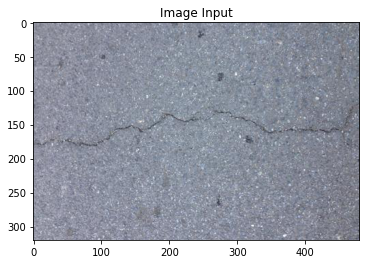

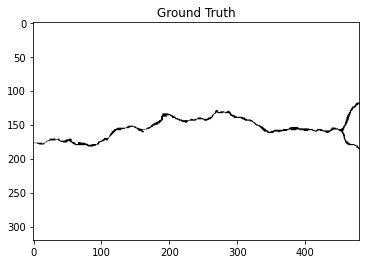

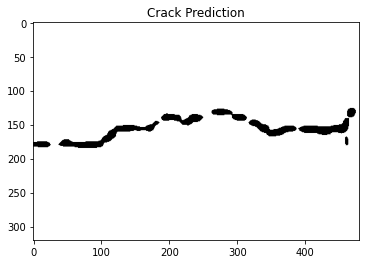

In [28]:
# Select a test image:
imno = 5

imList = os.listdir(os.path.join(data_path,'test','images'))
img = Image.open(os.path.join(data_path,'test','images',imList[imno]))
mask = Image.open(os.path.join(data_path,'test','masks',
                               imList[imno].split('.')[0])+'_label.PNG')

# Load the evaluation model:
modelEval = torch.load('crackdetector.pth')
modelEval.eval()

# Run the image through the segmentation model:
device = "cuda" if torch.cuda.is_available() else "cpu"

trf = transforms.Compose([transforms.ToTensor()])
inp = trf(img).unsqueeze(0).to(device)
scores = modelEval.to(device)(inp)['out']
pred = scores.detach().cpu().squeeze().numpy()
maskCrack = (pred>0.1).astype('uint8')

# Erode mask to thin out the crack lines (optional):
#maskCrack = cv2.erode(maskCrack,np.ones((10,10), np.uint8))

# Plot the predicted crack mask as well as the ground truth data:
plt.imshow(img); plt.title('Image Input'); plt.show()
plt.imshow(mask,cmap='Greys'); plt.title('Ground Truth'); plt.show()
plt.imshow(maskCrack,cmap='Greys'); plt.title('Crack Prediction'); plt.show()